In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import stats, signal, special, interpolate
import hera_cal as hc
import hera_pspec as hp
import healpy
import hera_sim as hs
import h5py
from memory_profiler import memory_usage
import uvtools as uvt
from cube2hpx import cube2hpx
import healvis as hv
from healvis.data import DATA_PATH
import os
from pyuvdata import UVData, UVBeam, utils as uvutils
import glob
from astropy.io import fits
import imp
import sim_utils

In [2]:
def loadfile(fname, dtype=np.float32, N=None):
    if N is None:
        return np.fromfile(fname, dtype=dtype)
    else:
        return np.fromfile(fname, dtype=dtype).reshape((N, N, N))

# Sky Simulation

In [3]:
# initialize cosmology
C = hp.conversions.Cosmo_Conversions()

## 1. Generate a mock 21 cm field in real space with a known power spectrum

In [4]:
# setup box
Npix = 256
dx = 2.0  # Mpc

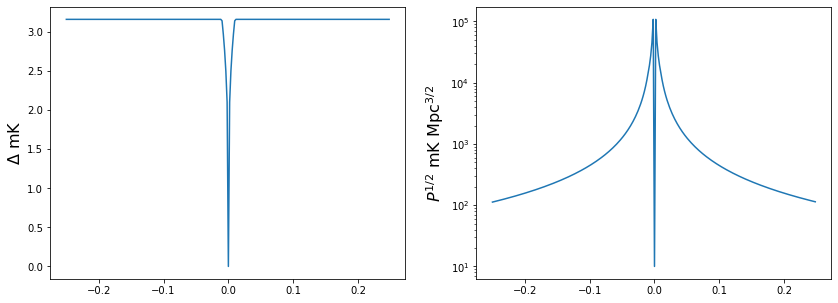

In [261]:
# define power spectra
k = np.fft.fftshift(np.fft.fftfreq(Npix, d=dx))
kx,ky,kz = np.meshgrid(k, k, k)
kmag = np.sqrt(kx**2 + ky**2 + kz**2)
Dk = np.sqrt(kmag).clip(1e-10, 1e0).astype(np.complex) * 1e8
Dk[Dk>10e6] = 10e6
#Dk = (kmag ** 3 * 1e8).astype(np.complex).clip(1e-4)

# give it some random phase XXX todo: make these binary 0 or pi
p = np.exp(1j*stats.uniform.rvs(0, 2*np.pi, Npix**3)).reshape(Npix, Npix, Npix)
Dk *= p
Pk = Dk / (kmag**3 / (2*np.pi**2)).clip(1e-10,)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax = axes[0]
ax.plot(k, np.sqrt(np.abs(Dk[128, 128])) / 1e3)
ax.set_ylabel(r'$\Delta$ mK', fontsize=16)
ax = axes[1]
ax.plot(k, np.sqrt(np.abs(Pk[128, 128])) / 1e3)
ax.set_ylabel(r'$P^{1/2}$ mK Mpc$^{3/2}$', fontsize=16)
ax.set_yscale('log')

In [262]:
# generate cube
sim = np.real(np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(Pk / np.sqrt(np.abs(Pk))), norm='ortho'))) / Npix**3

# one redshift
sim = sim[None, :, :, :]
simz = np.array([9.0])  # arbitrary

(10.0, 5000000.0)

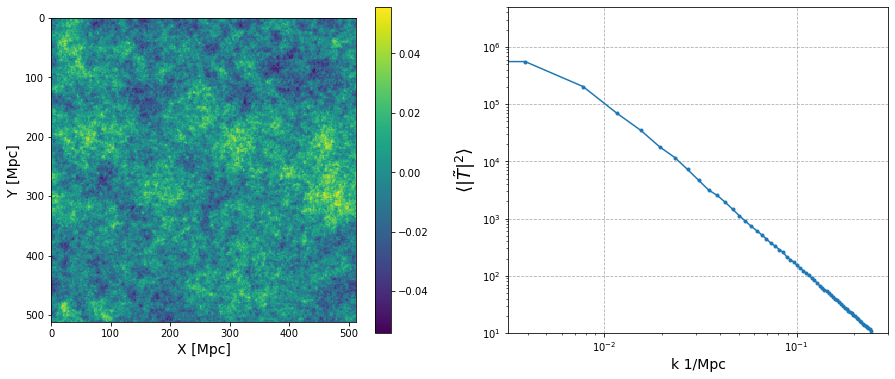

In [267]:
# plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# plot field
ax = axes[0]
cax = ax.imshow(sim[0, :, :, 64], extent=[0, dx*Npix, dx*Npix, 0])
ax.set_xlabel('X [Mpc]', fontsize=14); ax.set_ylabel('Y [Mpc]', fontsize=14)
cbar = fig.colorbar(cax, ax=ax)

# plot pspec
ax = axes[1]
w = uvt.dspec.gen_window('blackman', Npix)
w = w[None, None, :] * w[:, None, None] * w[None, :, None]
simfft = np.fft.fftshift(np.fft.fftn(sim[0] * w))
simpspec = np.real(simfft * simfft.conj()).ravel()
k = np.fft.fftshift(np.fft.fftfreq(Npix, d=dx))
kx,ky,kz = np.meshgrid(k, k, k)
kmag = np.sqrt(kx**2 + ky**2 + kz**2).ravel()
Nbins = 64
kbins = np.linspace(0, k.max(), Nbins, endpoint=False)
dk = np.diff(kbins)[0]
pspec = np.array([np.mean(simpspec[(kmag > kbins[i]) & (kmag <= kbins[i]+dk)]) for i in range(Nbins)])
ax.plot(kbins, pspec, marker='.')
ax.set_xlabel('k 1/Mpc', fontsize=14)
ax.set_ylabel(r'$\langle |\tilde{T}|^2\rangle$', fontsize=18)
ax.grid(ls='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e1, 5e6)

In [268]:
avg_cov = []
dnu = []
for i in range(len(simz)):
    # get pixel separation in MHz
    dnu.append(np.arange(Npix) * dx / C.dRpara_df(simz[i]) / 1e6)

    # get covariance
    cov = np.cov(sim[i].reshape(Npix, Npix**2))
    # roll covariance
    for j in range(cov.shape[0]):
        cov[j] = np.roll(cov[j], -j)
    
    # average covariance
    N = 50
    acov = np.mean(cov, axis=0)[:N]
    acov /= acov.max()
    avg_cov.append(acov)
    dnu[i] = dnu[i][:N]
    
avg_cov = np.array(avg_cov)
dnu = np.array(dnu)

Text(0.5, 0, '$\\Delta\\nu$ [MHz]')

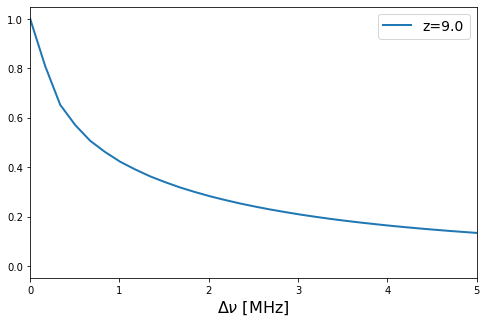

In [269]:
# plot covariance
fig, ax = plt.subplots(figsize=(8, 5))

for i in range(len(simz)):
    ax.plot(dnu[i], avg_cov[i], lw=2, label="z={:.1f}".format(simz[i]))

ax.set_xlim(0, 5)
ax.set_ylim(-.05, 1.05)
ax.legend(fontsize=14)
ax.set_xlabel(r'$\Delta\nu$ [MHz]', fontsize=16)

## 2. Or: load a 21cmFAST run

In [5]:
# load a sim
df = "../21cmFAST/Boxes/"
dfiles = sorted(glob.glob(df+'delta_T_v3_no_halos*'))
simz = np.array([float(df.split('_')[5][1:]) for df in dfiles])
dx = 1.0
sim = np.array([loadfile(df, N=512) for df in dfiles]) / 1e3  # put into Kelvin
Npix = 512

(100.0, 10000000.0)

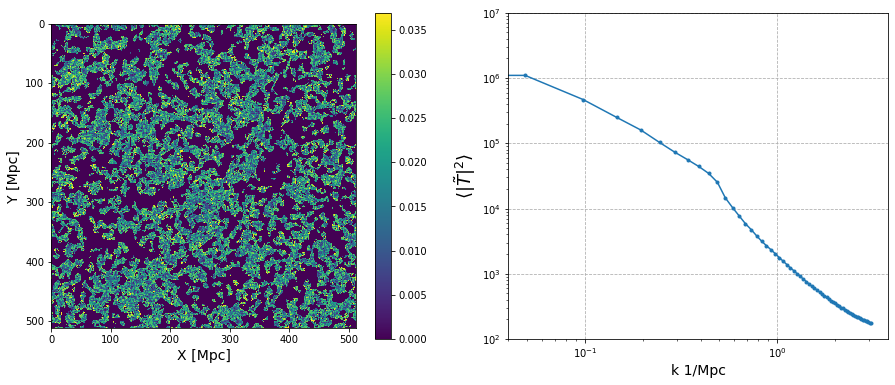

In [6]:
# plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
Npix = sim.shape[1]

# plot field
ax = axes[0]
cax = ax.imshow(sim[0, :, :, 256], extent=[0, dx*Npix, dx*Npix, 0])
ax.set_xlabel('X [Mpc]', fontsize=14); ax.set_ylabel('Y [Mpc]', fontsize=14)
cbar = fig.colorbar(cax, ax=ax)

# plot pspec
ax = axes[1]
w = uvt.dspec.gen_window('blackman', Npix)
w = w[None, None, :] * w[:, None, None] * w[None, :, None]
simfft = np.fft.fftshift(np.fft.fftn(sim[0] * w, ))
simpspec = np.real(simfft * simfft.conj()).ravel()
k = np.fft.fftshift(np.fft.fftfreq(Npix, d=dx)) * 2 * np.pi
kx,ky,kz = np.meshgrid(k, k, k)
kmag = np.sqrt(kx**2 + ky**2 + kz**2).ravel()
Nbins = 64
kbins = np.linspace(0, k.max(), Nbins, endpoint=False)
dk = np.diff(kbins)[0]
pspec = np.array([np.mean(simpspec[(kmag > kbins[i]) & (kmag <= kbins[i]+dk)]) for i in range(Nbins)])
ax.plot(kbins, pspec, marker='.')
ax.set_xlabel('k 1/Mpc', fontsize=14)
ax.set_ylabel(r'$\langle |\tilde{T}|^2\rangle$', fontsize=18)
ax.grid(ls='--')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e2, 1e7)

In [25]:
avg_cov = []
dnu = []
for i in range(len(simz)):
    # get pixel separation in MHz
    dnu.append(np.arange(Npix) * dx / C.dRpara_df(simz[i]) / 1e6)

    # get covariance
    cov = np.cov(sim[i].reshape(Npix, Npix**2))
    # roll covariance
    for j in range(cov.shape[0]):
        cov[j] = np.roll(cov[j], -j)
    
    # average covariance
    N = 50
    acov = np.mean(cov, axis=0)[:N]
    acov /= acov.max()
    avg_cov.append(acov)
    dnu[i] = dnu[i][:N]
    
avg_cov = np.array(avg_cov)
dnu = np.array(dnu)

Text(0.5, 0, '$\\Delta\\nu$ [MHz]')

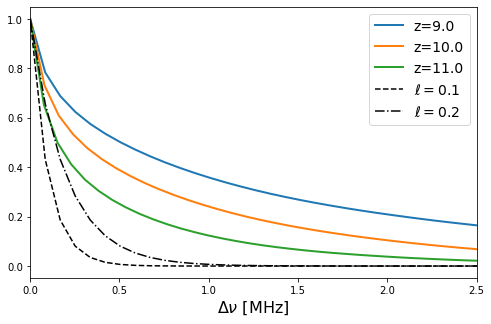

In [27]:
# plot covariance
fig, ax = plt.subplots(figsize=(8, 5))

for i in range(len(simz))[::4]:
    ax.plot(dnu[i], avg_cov[i], lw=2, label="z={:.1f}".format(simz[i]))

ax.plot(dnu[0], np.exp(-dnu[0] / 0.10), c='k', ls='--', label=r'$\ell=0.1$')
ax.plot(dnu[0], np.exp(-dnu[0] / 0.20), c='k', ls='-.', label=r'$\ell=0.2$')

ax.set_xlim(0, 2.5)
ax.set_ylim(-.05, 1.05)
ax.legend(fontsize=14)
ax.set_xlabel(r'$\Delta\nu$ [MHz]', fontsize=16)

Text(0.5, 0, '$\\Delta\\nu$ [MHz]')

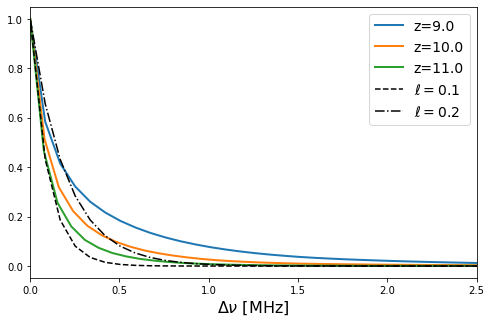

In [63]:
# plot covariance
fig, ax = plt.subplots(figsize=(8, 5))

for i in range(len(simz))[::4]:
    ax.plot(dnu[i], avg_cov[i], lw=2, label="z={:.1f}".format(simz[i]))

ax.plot(dnu[0], np.exp(-dnu[0] / 0.10), c='k', ls='--', label=r'$\ell=0.1$')
ax.plot(dnu[0], np.exp(-dnu[0] / 0.20), c='k', ls='-.', label=r'$\ell=0.2$')

ax.set_xlim(0, 2.5)
ax.set_ylim(-.05, 1.05)
ax.legend(fontsize=14)
ax.set_xlabel(r'$\Delta\nu$ [MHz]', fontsize=16)

## 3. Project onto HEALpix

In [7]:
# generate freqs
freqs = np.linspace(120e6, 140e6, 128, endpoint=False)
zs = np.array([C.f2z(f) for f in freqs])
#zs = np.array([9] * len(freqs))

In [8]:
# tile onto healpix
m = []
for f, z in zip(freqs, zs):
    m.append(cube2hpx(sim[np.argmin(np.abs(simz-z))], f/1e6, nside=256, sim_res=dx, sim_size=(Npix, Npix, Npix)))
m = np.array(m)

In [315]:
del sim, kmag, kx, ky, kz

/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/users/nkern/anaconda2/envs/py36/lib/python3.6/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


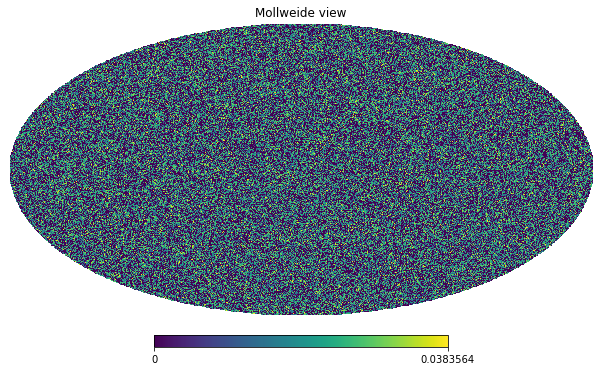

In [9]:
healpy.mollview(m[-1])

In [10]:
sky = hv.sky_model.SkyModel()
sky.set_data(m[:, :, None].T)
sky.freqs = freqs
sky.Nside = healpy.npix2nside(m.shape[1])
sky._update()
del m

In [38]:
memory_usage()

[13547.796875]

In [11]:
sky.write_hdf5('../data/eor_sky_21cmFAST_default_NSIDE256_run4.h5', clobber=True)

...writing ../data/eor_sky_21cmFAST_default_NSIDE256_run4.h5


## 2. Generate GSM healpix maps

In [ ]:
gsm = hv.sky_model.gsm_shell(256, freqs)

In [ ]:
sky = hv.sky_model.SkyModel()
sky.set_data(gsm[None, :, :])
sky.freqs = freqs
sky.Nside = 256
sky._update()

In [420]:
sky.write_hdf5("../data/gsm_sky_NSIDE256.h5", clobber=True)

...writing ../data/gsm_sky_NSIDE256.h5


In [97]:
sky = hv.sky_model.SkyModel()
sky.read_hdf5('../data/gsm_sky_NSIDE256.h5')

...reading ../data/gsm_sky_NSIDE256.h5


In [13]:
# load full object, get reds
uvd = hv.simulator.setup_uvdata(array_layout=os.path.join(DATA_PATH, "configs/HERA65_layout.csv"),
                                telescope_location=(-30.72152777777791, 21.428305555555557, 1073.0000000093132),
                                telescope_name="HERA", Ntimes=1, time_cadence=1, start_time=2458000.53,
                                pols=['xx'], run_check=True, freq_array=sky.freqs, make_full=False)
reds, lens, angs = hp.utils.get_reds(uvd, bl_len_range=(10, 40))
inds = [ind for ind in np.arange(len(reds)) if len(reds[ind]) > 5]
reds, lens, angs = [reds[i] for i in inds], [lens[i] for i in inds], [angs[i] for i in inds]
print(len(reds))
bls = [red[0] for red in reds] + [(0, 0)]

Nbls: 2080
15


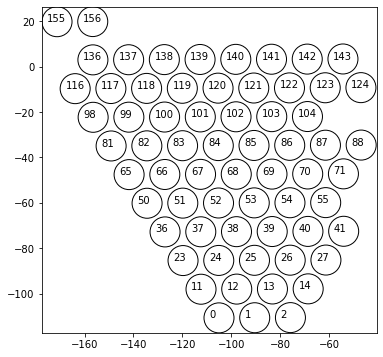

In [31]:
antpos, ants = uvd.get_ENU_antpos()
plt.figure(figsize=(6,6))
plt.scatter(antpos[:, 0], antpos[:, 1], facecolor='', edgecolor='k', s=900)
for i, a in enumerate(ants):
    plt.text(antpos[i,0]-4,antpos[i,1],a,fontsize=10,color='k')

In [14]:
# setup empty uvdata
uvd = hv.simulator.setup_uvdata(array_layout=os.path.join(DATA_PATH, "configs/HERA65_layout.csv"),
                                telescope_location=(-30.72152777777791, 21.428305555555557, 1073.0000000093132),
                                telescope_name="HERA", Ntimes=100, time_cadence=300.0, start_time=2458000.53,
                                pols=['xx'], bls=bls, run_check=True, freq_array=sky.freqs, make_full=True)
uvd.write_uvh5('../data/eor_sim_21cmFAST_default_NSIDE256_run4.uvh5', clobber=True)

Nbls: 15


In [30]:
# setup empty uvdata
uvd = hv.simulator.setup_uvdata(array_layout=os.path.join(DATA_PATH, "configs/HERA65_layout.csv"),
                                telescope_location=(-30.72152777777791, 21.428305555555557, 1073.0000000093132),
                                telescope_name="HERA", Ntimes=100, time_cadence=300.0, start_time=2458000.53,
                                pols=['xx'], bls=bls, run_check=True, freq_array=sky.freqs, make_full=True,
                                no_autos=False)
uvd.write_uvh5('../data/gsm_sim_NSIDE256_2.uvh5', clobber=True)

Nbls: 16


In [15]:
# get analytic beam
beam = hv.beam_model.AnalyticBeam('airy', diameter=14.0)

In [ ]:
# run simulation
freq_chans = np.arange(len(freqs))
hv.simulator.run_simulation_partial_freq(freq_chans, '../data/eor_sim_21cmFAST_default_NSIDE256_run4.uvh5',
                                         '../data/eor_sky_21cmFAST_default_NSIDE256_run4.h5',
                                         fov=180, beam=beam)

antenna_diameters is not set. Using known values for HERA.


In [ ]:
# run simulation
freq_chans = np.arange(len(freqs))
hv.simulator.run_simulation_partial_freq(freq_chans, '../data/gsm_sim_NSIDE256_2.uvh5',
                                         '../data/gsm_sky_NSIDE256.h5',
                                         fov=180, beam=beam)

...reading ../data/gsm_sky_NSIDE256.h5
Finished: 1, Elapsed 1.45min, Remain 2.390hour, MaxRSS 1.835676GB
Finished: 2, Elapsed 2.88min, Remain 2.353hour, MaxRSS 5.010488GB
Finished: 3, Elapsed 4.32min, Remain 2.326hour, MaxRSS 5.018348GB
Finished: 4, Elapsed 5.76min, Remain 2.303hour, MaxRSS 5.02142GB
Finished: 5, Elapsed 7.20min, Remain 2.280hour, MaxRSS 5.02142GB
Finished: 6, Elapsed 8.64min, Remain 2.256hour, MaxRSS 5.02142GB
Finished: 7, Elapsed 10.08min, Remain 2.231hour, MaxRSS 5.02142GB
Finished: 8, Elapsed 11.51min, Remain 2.207hour, MaxRSS 5.02142GB
Finished: 9, Elapsed 12.95min, Remain 2.182hour, MaxRSS 5.02142GB
Finished: 10, Elapsed 14.38min, Remain 2.156hour, MaxRSS 5.02142GB
Finished: 11, Elapsed 15.80min, Remain 2.130hour, MaxRSS 5.021572GB
Finished: 12, Elapsed 17.24min, Remain 2.107hour, MaxRSS 5.021572GB
Finished: 13, Elapsed 18.68min, Remain 2.084hour, MaxRSS 5.021572GB
Finished: 14, Elapsed 20.12min, Remain 2.060hour, MaxRSS 5.021572GB
Finished: 15, Elapsed 21.55min,

In [3]:
# make noise
uvd = UVData()
uvd.read("../data/gsm_sim_NSIDE256.uvh5")
uvn = uvd.select(bls=[bl for bl in uvd.get_antpairs() if bl[0] != bl[1]], inplace=False)

antenna_diameters is not set. Using known values for HERA.


In [8]:
omega_p = hs.noise.bm_poly_to_omega_p(freqs/1e9)

In [35]:
for seed in range(100):
    autoK = uvd.get_data(0,0,'xx') * hs.noise.jy2T(freqs/1e9, omega_p) / 1e3
    lsts = np.unique(uvd.lst_array)
    Trxr = 150
    np.random.seed(seed)
    for i, ap in enumerate(uvn.get_antpairs()):
        inds = uvn.antpair2ind(ap)
        uvn.data_array[inds, 0, :, 0] = hs.noise.sky_noise_jy(autoK + Trxr, freqs/1e9, lsts, omega_p, inttime=10.7)
        
    uvn.write_uvh5("../data/noise{:03d}_sim.uvh5".format(seed+1), clobber=True)

## point sources

In [97]:
freqs = np.linspace(120e6, 140e6, 128, endpoint=False)

In [4]:
imp.reload(sim_utils)

<module 'sim_utils' from '/lustre/aoc/projects/hera/nkern/gpr_errs_21cm/notebooks/sim_utils.py'>

In [98]:
m = sim_utils.populate_point_sources("../../abscal/gleam.fits", freqs, nside=256, minflux=0.5)

divide by zero encountered in log10

The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.

The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.


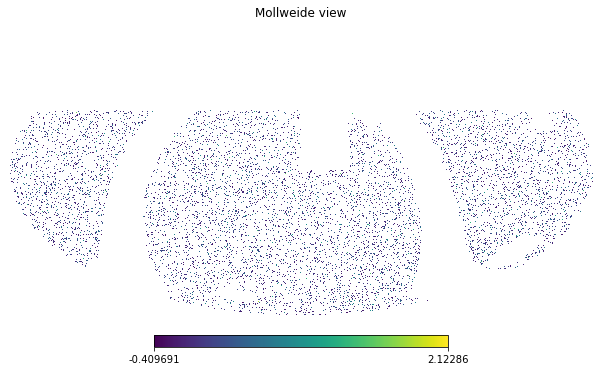

In [99]:
healpy.mollview(np.log10(m[0]))

In [100]:
sky = hv.sky_model.SkyModel()
sky.set_data(m.T[None])
sky.freqs = freqs
sky.Nside = healpy.npix2nside(m.shape[1])
sky._update()

In [101]:
sky.write_hdf5("../data/gleam_sky_NSIDE{}.h5".format(sky.Nside), clobber=True)

...writing ../data/gleam_sky_NSIDE256.h5


In [137]:
sky = hv.sky_model.SkyModel()
sky.read_hdf5('../data/gleam_sky_NSIDE256.h5')

...reading ../data/gleam_sky_NSIDE256.h5


In [104]:
# get analytic beam
beam = hv.beam_model.AnalyticBeam('airy', diameter=14.0)

In [105]:
# setup empty uvdata
uvd = hv.simulator.setup_uvdata(array_layout=os.path.join(DATA_PATH, "configs/HERA65_layout.csv"),
                                telescope_location=(-30.72152777777791, 21.428305555555557, 1073.0000000093132),
                                telescope_name="HERA", Ntimes=100, time_cadence=300.0, start_time=2458000.53,
                                pols=['xx'], bls=bls, run_check=True, freq_array=sky.freqs, make_full=True,
                                no_autos=False)
uvd.write_uvh5('../data/gleam_sim_NSIDE256.uvh5', clobber=True)

Nbls: 16
File exists; clobbering


In [ ]:
# run simulation
freq_chans = np.arange(len(freqs))
hv.simulator.run_simulation_partial_freq(freq_chans, '../data/gleam_sim_NSIDE256.uvh5',
                                         '../data/gleam_sky_NSIDE256.h5',
                                         fov=180, beam=beam)

antenna_diameters is not set. Using known values for HERA.


...reading ../data/gleam_sky_NSIDE256.h5
Finished: 1, Elapsed 1.46min, Remain 2.411hour, MaxRSS 1.809072GB
Finished: 2, Elapsed 2.89min, Remain 2.357hour, MaxRSS 4.979396GB
Finished: 3, Elapsed 4.33min, Remain 2.333hour, MaxRSS 4.989468GB
Finished: 4, Elapsed 5.79min, Remain 2.314hour, MaxRSS 4.989468GB
Finished: 5, Elapsed 7.24min, Remain 2.292hour, MaxRSS 4.992496GB
Finished: 6, Elapsed 8.68min, Remain 2.267hour, MaxRSS 4.992496GB
Finished: 7, Elapsed 10.14min, Remain 2.245hour, MaxRSS 4.992496GB
Finished: 8, Elapsed 11.59min, Remain 2.221hour, MaxRSS 4.992496GB
Finished: 9, Elapsed 13.03min, Remain 2.196hour, MaxRSS 4.992496GB
Finished: 10, Elapsed 14.49min, Remain 2.174hour, MaxRSS 4.992496GB
Finished: 11, Elapsed 15.94min, Remain 2.150hour, MaxRSS 4.992496GB
Finished: 12, Elapsed 17.37min, Remain 2.124hour, MaxRSS 4.992496GB
Finished: 13, Elapsed 18.82min, Remain 2.099hour, MaxRSS 4.992496GB
Finished: 14, Elapsed 20.26min, Remain 2.075hour, MaxRSS 4.992496GB
Finished: 15, Elapsed 

In [82]:
u1, u2, u3, u4 = UVData(), UVData(), UVData(), UVData()
u1.read('../data/gleam_sim_NSIDE64.uvh5')
u2.read('../data/gleam_sim_NSIDE128.uvh5')
u3.read('../data/gleam_sim_NSIDE256.uvh5')
u4.read('../data/gleam_sim_NSIDE512.uvh5')

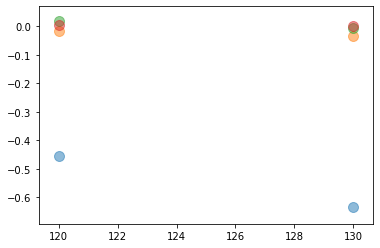

In [87]:
k = (0, 2, 'xx')
k = (23, 27, 'xx')
plt.scatter(f, np.real(u1.get_data(k)[0]), s=100, alpha=0.5)
plt.scatter(f, np.real(u2.get_data(k)[0]), s=100, alpha=0.5)
plt.scatter(f, np.real(u3.get_data(k)[0]), s=100, alpha=0.5)
plt.scatter(f, np.real(u4.get_data(k)[0]), s=100, alpha=0.5)

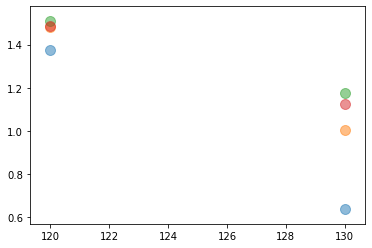

In [93]:
k = (0, 2, 'xx')
#k = (23, 27, 'xx')
plt.scatter(f, np.angle(u1.get_data(k)[0]), s=100, alpha=0.5)
plt.scatter(f, np.angle(u2.get_data(k)[0]), s=100, alpha=0.5)
plt.scatter(f, np.angle(u3.get_data(k)[0]), s=100, alpha=0.5)
plt.scatter(f, np.angle(u4.get_data(k)[0]), s=100, alpha=0.5)

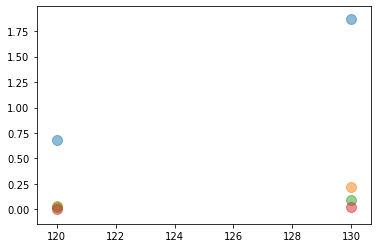

In [91]:
k = (0, 2, 'xx')
k = (23, 27, 'xx')
plt.scatter(f, np.abs(u1.get_data(k)[0]), s=100, alpha=0.5)
plt.scatter(f, np.abs(u2.get_data(k)[0]), s=100, alpha=0.5)
plt.scatter(f, np.abs(u3.get_data(k)[0]), s=100, alpha=0.5)
plt.scatter(f, np.abs(u4.get_data(k)[0]), s=100, alpha=0.5)

## 3. Inspect

In [17]:
import copy

In [34]:
uvd1 = UVData()
uvd1.read('../data/gsm_sim_NSIDE256.uvh5')
uvd1.select(bls=[bl for bl in uvd.get_antpairs() if bl[0] != bl[1]])
uvd2 = UVData()
uvd2.read("../data/eor_sim_21cmFAST_default_NSIDE256.uvh5")
uvd3 = UVData()
uvd3.read("../data/noise001_sim.uvh5")
uvd4 = UVData()
uvd4.read("../data/gleam_sim_NSIDE256.uvh5")
uvd4.select(bls=[bl for bl in uvd4.get_antpairs() if bl[0] != bl[1]])
uvd = copy.deepcopy(uvd1)
uvd.data_array += uvd2.data_array + uvd3.data_array / 1e5 + uvd4.data_array

In [35]:
D = hc.frf.FRFilter(uvd)
F = hc.frf.FRFilter(uvd1)
G = hc.frf.FRFilter(uvd4)
E = hc.frf.FRFilter(uvd2)
N = hc.frf.FRFilter(uvd3)

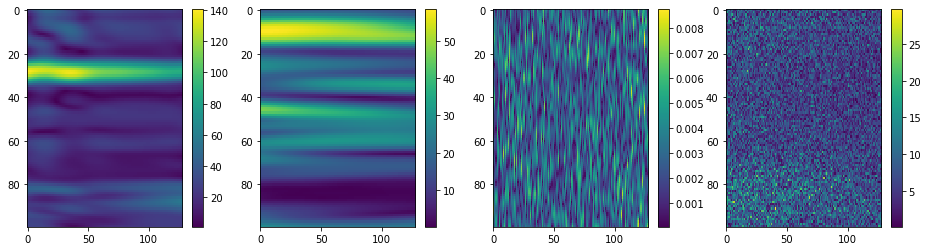

In [36]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.subplots_adjust(wspace=0.2)
k = (0, 38, 'xx')

ax = axes[0]
cax = ax.imshow(np.abs(F.data[k]), aspect='auto')
fig.colorbar(cax, ax=ax)

ax = axes[1]
cax = ax.imshow(np.abs(G.data[k]), aspect='auto')
fig.colorbar(cax, ax=ax)

ax = axes[2]
cax = ax.imshow(np.abs(E.data[k]), aspect='auto')
fig.colorbar(cax, ax=ax)

ax = axes[3]
cax = ax.imshow(np.abs(N.data[k]), aspect='auto')
fig.colorbar(cax, ax=ax)

In [37]:
D.fft_data(window='bh7', overwrite=True)
E.fft_data(window='bh7', overwrite=True)

In [38]:
t2k = C.tau_to_kpara(C.f2z(np.mean(freqs)))

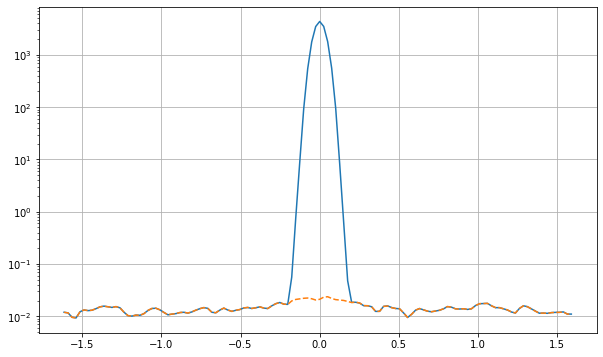

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
kbins = D.delays*t2k/1e9
k = (0, 1, 'xx')

ax.plot(kbins, np.mean(np.abs(D.dfft[k]), axis=0))
ax.plot(kbins, np.mean(np.abs(E.dfft[k]), axis=0), ls='--')
ax.set_yscale('log')
ax.grid()

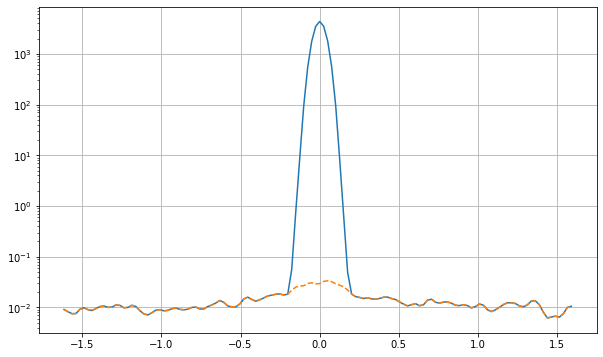

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
kbins = D.delays*t2k/1e9
k = (0, 1, 'xx')

ax.plot(kbins, np.mean(np.abs(D.dfft[k]), axis=0))
ax.plot(kbins, np.mean(np.abs(E.dfft[k]), axis=0), ls='--')
ax.set_yscale('log')
ax.grid()

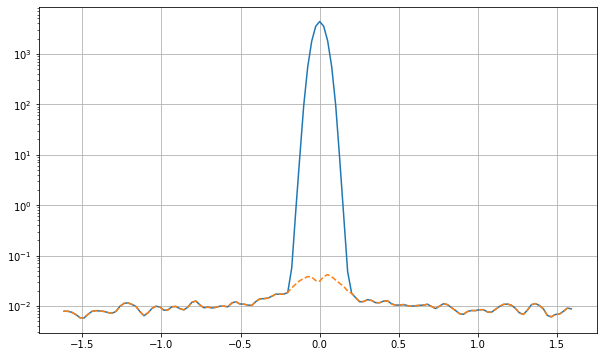

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
kbins = D.delays*t2k/1e9
k = (0, 1, 'xx')

ax.plot(kbins, np.mean(np.abs(D.dfft[k]), axis=0))
ax.plot(kbins, np.mean(np.abs(E.dfft[k]), axis=0), ls='--')
ax.set_yscale('log')
ax.grid()

In [40]:
# get covariance of all data
zs = C.f2z(freqs)
cov1 = np.cov(E.hd.data_array.squeeze()[:, :64].T)
cov2 = np.cov(E.hd.data_array.squeeze()[:, 64:].T)

# roll covariance
for j in range(cov1.shape[0]):
    cov1[j] = np.roll(cov1[j], -j)
    cov2[j] = np.roll(cov2[j], -j)

# average covariance
N = 20
acov1 = np.mean(cov1, axis=0)[:N]
acov2 = np.mean(cov2, axis=0)[:N]
acov1 /= acov1.max()
acov2 /= acov2.max()
dnu = (freqs - freqs[0])[:N]/1e6

(-0.02, 1.02)

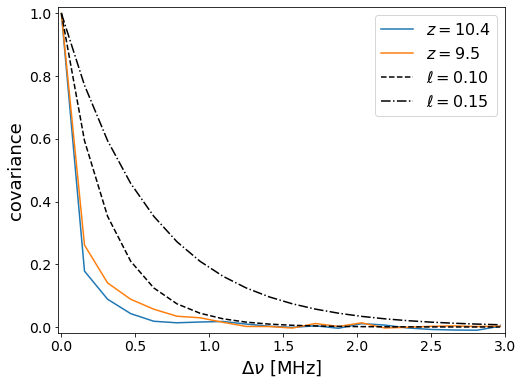

In [41]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.tick_params(labelsize=14)

ax.plot(dnu, acov1, label=r'$z={:.1f}$'.format(zs[32]))
ax.plot(dnu, acov2, label=r'$z={:.1f}$'.format(zs[96]))
ax.plot(dnu, np.exp(-dnu / 0.3), c='k', ls='--', label=r"$\ell=0.10$")
ax.plot(dnu, np.exp(-dnu / 0.6), c='k', ls='-.', label=r"$\ell=0.15$")

ax.set_xlabel(r'$\Delta\nu$ [MHz]', fontsize=18)
ax.set_ylabel('covariance', fontsize=18)
ax.legend(fontsize=16)
ax.set_xlim(-.02, 3)
ax.set_ylim(-.02, 1.02)